In [ ]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns

In [ ]:
import json
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
json_file_path = "/content/drive/MyDrive/newsHeadlinesDataset.json"

In [ ]:
sarcastic_count = 0
non_sarcastic_count = 0

# Read JSON file and parse each row
with open(json_file_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        is_sarcastic = data.get("is_sarcastic", 0)
        if is_sarcastic == 1:
            sarcastic_count += 1
        elif is_sarcastic == 0:
            non_sarcastic_count += 1

# Print the counts
print("Number of sarcastic headlines:", sarcastic_count)
print("Number of non-sarcastic headlines:", non_sarcastic_count)

Number of sarcastic headlines: 13634
Number of non-sarcastic headlines: 14985


In [ ]:


# Initialize variables to store total number of words and total number of headlines
total_words = 0
total_headlines = 0

# Open the JSON file
with open(json_file_path, 'r') as f:
    # Iterate through each line in the file
    for line in f:
        # Parse the JSON object from the current line
        try:
            data = json.loads(line)
        except json.JSONDecodeError:
            # Skip invalid JSON lines
            continue

        # Increment the total number of headlines
        total_headlines += 1

        # Split the headline string into words
        words = data.get('headline', '').split()

        # Increment the total number of words by the number of words in the current headline
        total_words += len(words)

# Calculate the average number of words
if total_headlines > 0:
    average_words = total_words / total_headlines
    print("Average number of words per headline:", average_words)
else:
    print("No valid headlines found in the JSON file.")


Average number of words per headline: 10.049966805269227


In [ ]:
# Read the JSON file and create the DataFrame
headlines = []
labels = []

with open(json_file_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        headlines.append(data['headline'])
        labels.append(data['is_sarcastic'])

In [ ]:
print(f'headlines : {len(headlines)}')
print(f'labels : {len(labels)}')

headlines : 28619
labels : 28619


In [ ]:
df = pd.DataFrame({
    'headline': headlines,
    'is_sarcastic': labels
})

print(df.head())

                                            headline  is_sarcastic
0  thirtysomething scientists unveil doomsday clo...             1
1  dem rep. totally nails why congress is falling...             0
2  eat your veggies: 9 deliciously different recipes             0
3  inclement weather prevents liar from getting t...             1
4  mother comes pretty close to using word 'strea...             1


In [ ]:
df['headline_length'] = df.apply(lambda row: len(row['headline']), axis=1)
df['headline_words_count'] = df.apply(lambda row: len(row['headline'].split(' ')), axis=1)
df.head()

,headline,is_sarcastic,headline_length,headline_words_count
0,thirtysomething scientists unveil doomsday clo...,1,61,8
1,dem rep. totally nails why congress is falling...,0,79,13
2,eat your veggies: 9 deliciously different recipes,0,49,7
3,inclement weather prevents liar from getting t...,1,52,8
4,mother comes pretty close to using word 'strea...,1,61,9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   headline              28619 non-null  object
 1   is_sarcastic          28619 non-null  int64 
 2   headline_length       28619 non-null  int64 
 3   headline_words_count  28619 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 894.5+ KB


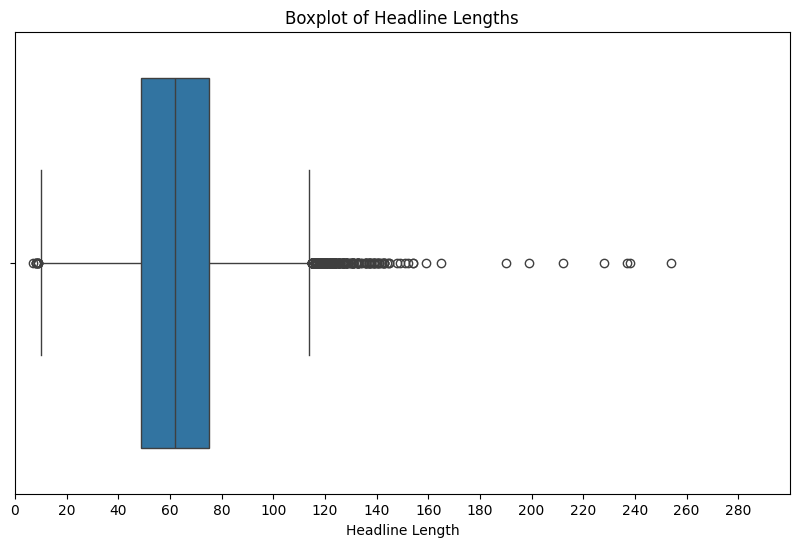

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['headline_length'])
plt.title('Boxplot of Headline Lengths')
plt.xlabel('Headline Length')
plt.xlim(0, 300)
plt.xticks(range(0, 300, 20))
plt.show()

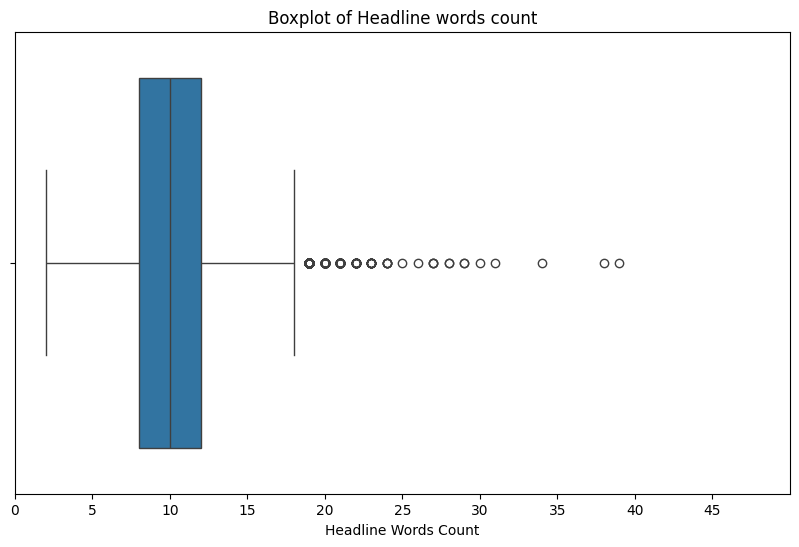

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['headline_words_count'])
plt.title('Boxplot of Headline words count')
plt.xlabel('Headline Words Count')
plt.xlim(0, 50)
plt.xticks(range(0, 50, 5))
plt.show()

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [ ]:
df['headline'] = df['headline'].apply(preprocess_text)
df.head()

,headline,is_sarcastic,headline_length,headline_words_count
0,thirtysomething scientists unveil doomsday clo...,1,61,8
1,dem rep totally nails congress falling short g...,0,79,13
2,eat veggies 9 deliciously different recipes,0,49,7
3,inclement weather prevents liar getting work,1,52,8
4,mother comes pretty close using word streaming...,1,61,9


In [ ]:
df['headline_length'] = df.apply(lambda row: len(row['headline']), axis=1)
df['headline_words_count'] = df.apply(lambda row: len(row['headline'].split(' ')), axis=1)
df.head()

,headline,is_sarcastic,headline_length,headline_words_count
0,thirtysomething scientists unveil doomsday clo...,1,58,7
1,dem rep totally nails congress falling short g...,0,67,10
2,eat veggies 9 deliciously different recipes,0,43,6
3,inclement weather prevents liar getting work,1,44,6
4,mother comes pretty close using word streaming...,1,56,8


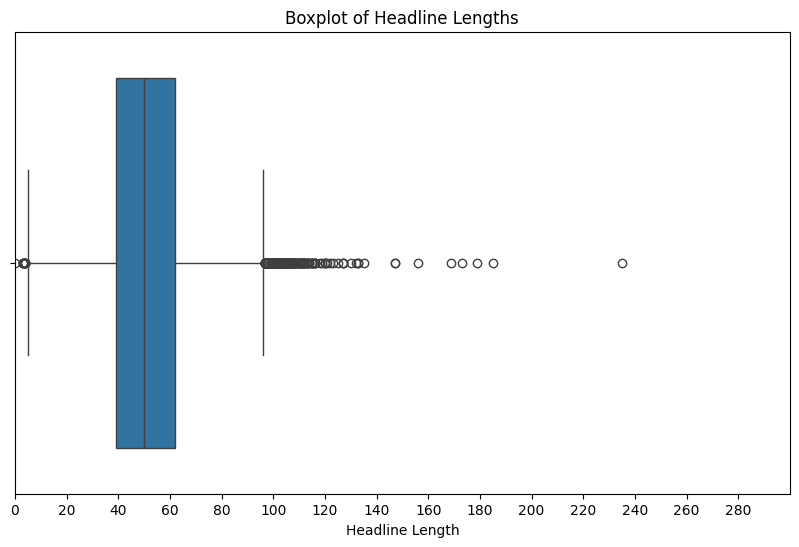

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['headline_length'])
plt.title('Boxplot of Headline Lengths')
plt.xlabel('Headline Length')
plt.xlim(0, 300)
plt.xticks(range(0, 300, 20))
plt.show()

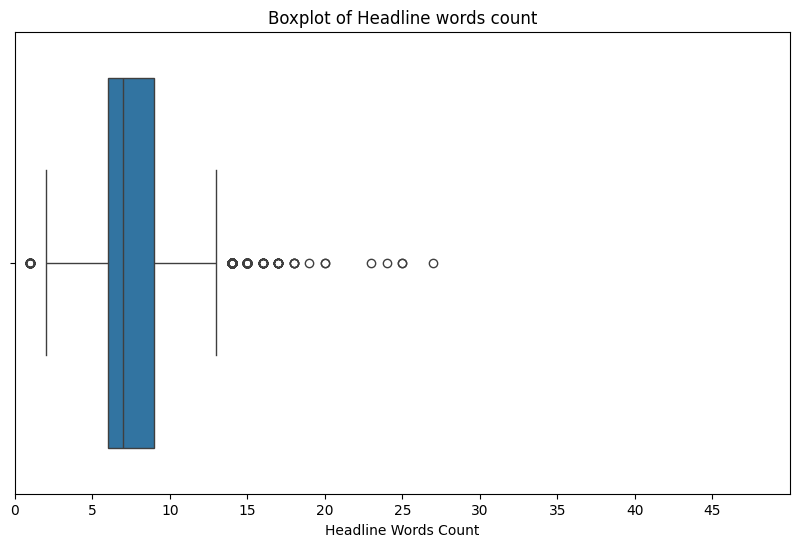

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['headline_words_count'])
plt.title('Boxplot of Headline words count')
plt.xlabel('Headline Words Count')
plt.xlim(0, 50)
plt.xticks(range(0, 50, 5))
plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
print(f'Training set shape: {train_df.shape}')
print(f'Test set shape: {test_df.shape}')
print(f'Validation set shape: {val_df.shape}')

Training set shape: (20605, 2)
Test set shape: (5724, 2)
Validation set shape: (2290, 2)


In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize the headlines without truncation or padding to analyze lengths
all_encodings = tokenizer(train_df['headline'].tolist(), truncation=False, padding=False)
token_lengths = [len(enc) for enc in all_encodings['input_ids']]

# Print statistics
print(f"Max length: {max(token_lengths)}")
print(f"95th percentile length: {np.percentile(token_lengths, 95)}")
print(f"Mean length: {np.mean(token_lengths)}")

Max length: 42
95th percentile length: 16.0
Mean length: 10.899830138315943


In [ ]:
# Tokenize the training data
train_encodings = tokenizer(train_df['headline'].tolist(), truncation=True, padding=True, max_length=16)
val_encodings = tokenizer(val_df['headline'].tolist(), truncation=True, padding=True, max_length=16)
test_encodings = tokenizer(test_df['headline'].tolist(), truncation=True, padding=True, max_length=16)

# Convert labels to tensors
train_labels = train_df['is_sarcastic'].tolist()
val_labels = val_df['is_sarcastic'].tolist()
test_labels = test_df['is_sarcastic'].tolist()

In [ ]:
print("Input IDs:", train_encodings['input_ids'][0])
print("Attention Mask:", train_encodings['attention_mask'][0])

Input IDs: [101, 2996, 4378, 4122, 2265, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print("Length of Input IDs:", len(train_encodings['input_ids']))
print("Length of Input IDs element:", len(train_encodings['input_ids'][0]))

Length of Input IDs: 20605
Length of Input IDs element: 16


In [ ]:
import torch
from transformers import BertModel

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Set the model to evaluation mode
bert_model.eval()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# def get_bert_embeddings(encodings):
#     input_ids = torch.tensor(encodings['input_ids'])
#     attention_mask = torch.tensor(encodings['attention_mask'])

#     with torch.no_grad():
#         outputs = bert_model(input_ids, attention_mask=attention_mask)

#     embeddings = outputs.last_hidden_state[:, 0, :]

#     return embeddings

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# def get_bert_embeddings(encodings, bert_model, device='cuda'):

#     input_ids = torch.tensor(encodings['input_ids']).to(device)
#     attention_mask = torch.tensor(encodings['attention_mask']).to(device)

#     with torch.no_grad():
#         bert_model = bert_model.to(device)
#         outputs = bert_model(input_ids, attention_mask=attention_mask)

#     embeddings = outputs.last_hidden_state[:, 0, :]
#     embeddings = embeddings.cpu() if device == 'cpu' else embeddings
#     return embeddings

In [ ]:
def get_bert_embeddings(encodings, bert_model, device='cuda', batch_size=8):
    input_ids_all = encodings['input_ids']
    attention_mask_all = encodings['attention_mask']
    num_examples = len(input_ids_all)

    embeddings_list = []

    # Process data in batches
    for start_idx in range(0, num_examples, batch_size):
        end_idx = min(start_idx + batch_size, num_examples)
        input_ids = torch.tensor(input_ids_all[start_idx:end_idx]).to(device)
        attention_mask = torch.tensor(attention_mask_all[start_idx:end_idx]).to(device)

        with torch.no_grad():
            bert_model = bert_model.to(device)
            outputs = bert_model(input_ids, attention_mask=attention_mask)

        embeddings = outputs.last_hidden_state[:, 0, :].cpu()  # Move embeddings to CPU
        embeddings_list.append(embeddings)

        # Free GPU memory explicitly after each batch
        del input_ids, attention_mask, outputs
        torch.cuda.empty_cache()

    # Concatenate embeddings from all batches
    embeddings_all = torch.cat(embeddings_list, dim=0)

    return embeddings_all


In [ ]:
# train_embeddings = get_bert_embeddings(train_encodings, bert_model, device=device)

In [ ]:
# test_embeddings = get_bert_embeddings(test_encodings, bert_model, device=device)

In [ ]:
# val_embeddings = get_bert_embeddings(val_encodings, bert_model, device=device)

In [ ]:
# print(train_embeddings.shape)
# print(test_embeddings.shape)
# print(val_embeddings.shape)

In [ ]:
# train_embeddings_np = train_embeddings.cpu().numpy()
# test_embeddings_np = test_embeddings.cpu().numpy()
# val_embeddings_np = val_embeddings.cpu().numpy()

# print("Train embeddings shape:", train_embeddings_np.shape)
# print("Test embeddings shape:", test_embeddings_np.shape)

In [ ]:
# print("Train labels type:", type(train_labels))
# print("Test labels type:", type(test_labels))
# print("Val labels type:", type(val_labels))

In [ ]:
# train_labels_np = np.array(train_labels)
# val_labels_np = np.array(val_labels)
# test_labels_np = np.array(test_labels)

In [ ]:
train_embeddings_np = np.load('/content/drive/MyDrive/train_embeddings_np.npy')
val_embeddings_np = np.load('/content/drive/MyDrive/val_embeddings_np.npy')
test_embeddings_np = np.load('/content/drive/MyDrive/test_embeddings_np.npy')
train_labels_np = np.load('/content/drive/MyDrive/train_labels_np.npy')
test_labels_np = np.load('/content/drive/MyDrive/test_labels_np.npy')
val_labels_np = np.load('/content/drive/MyDrive/val_labels_np.npy')

In [ ]:
print("Train labels type:", type(train_labels_np))
print("Test labels type:", type(test_labels_np))
print("Val labels type:", type(val_labels_np))
print("Train embeddings shape:", train_embeddings_np.shape)
print("Test embeddings shape:", test_embeddings_np.shape)
print("Val embeddings shape:", val_embeddings_np.shape)

Train labels type: <class 'numpy.ndarray'>
Test labels type: <class 'numpy.ndarray'>
Val labels type: <class 'numpy.ndarray'>
Train embeddings shape: (20605, 768)
Test embeddings shape: (5724, 768)
Val embeddings shape: (2290, 768)


In [ ]:
from keras.optimizers import Adam

In [ ]:
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(train_embeddings.shape[1],)),
#     Dropout(0.15),
#     Dense(1, activation='sigmoid')
# ])

In [ ]:
# model.compile(optimizer=Adam(learning_rate=1e-6),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
# history = model.fit(train_embeddings_np, train_labels_np,
#                     epochs=10,
#                     batch_size=32,
#                     validation_data=(val_embeddings_np, val_labels_np))

In [ ]:
#np.save('/content/drive/MyDrive/train_embeddings_np', train_embeddings_np)
#np.save('/content/drive/MyDrive/val_embeddings_np', val_embeddings_np)
#np.save('/content/drive/MyDrive/test_embeddings_np', test_embeddings_np)

# np.save('/content/drive/test_embeddings_np', test_embeddings_np)
# /content/drive/MyDrive/vibhor aadhar.pdf

In [ ]:
# np.save('/content/drive/MyDrive/train_labels_np', train_labels_np)
# np.save('/content/drive/MyDrive/test_labels_np', test_labels_np)
# np.save('/content/drive/MyDrive/val_labels_np', val_labels_np)

In [ ]:
# train_embeddings_np = np.load('train_embeddings.npy')
# test_embeddings_np = np.load('test_embeddings.npy')
# train_labels_np = np.load('train_labels.npy')
# test_labels_np = np.load('test_labels.npy')

In [ ]:
#!pip install keras-tuner

In [ ]:
# import keras_tuner as kt

# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),
#                     activation='relu', input_shape=(train_embeddings.shape[1],)))
#     model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-6, 1e-5, 1e-4])),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

In [ ]:
# tuner = kt.Hyperband(build_model,
#                      objective='val_accuracy',
#                      max_epochs=12,
#                      factor=3,
#                      directory='my_dir',
#                      project_name='hyperparameter_tuning')

# tuner.search(train_embeddings_np, train_labels_np,
#              epochs=12,
#              validation_data=(val_embeddings_np, val_labels_np))


# best_model = tuner.get_best_models(num_models=1)[0]


# best_model.summary()

In [ ]:
# best_model.summary()

In [ ]:

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


# print(f"Optimal number of units in the first dense layer: {best_hps.get('units')}")
# print(f"Optimal dropout rate: {best_hps.get('dropout')}")
# print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

In [ ]:
best_model = Sequential([
    Dense(224, activation='relu', input_shape=(train_embeddings_np.shape[1],)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
best_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(best_model.summary())

history = best_model.fit(train_embeddings_np, train_labels_np,
                    epochs=12,
                    batch_size=32,
                    validation_data=(val_embeddings_np, val_labels_np))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               172256    
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 225       
                                                                 
Total params: 172481 (673.75 KB)
Trainable params: 172481 (673.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/12
644/644 [==============================] - 7s 6ms/step - loss: 0.5853 - accuracy: 0.6910 - val_loss: 0.5358 - val_accuracy: 0.7419
Epoch 2/12
644/644 [==============================] - 2s 4ms/step - loss: 0.5168 - accuracy: 0.7508 - val_loss: 0.5085 - val_accuracy

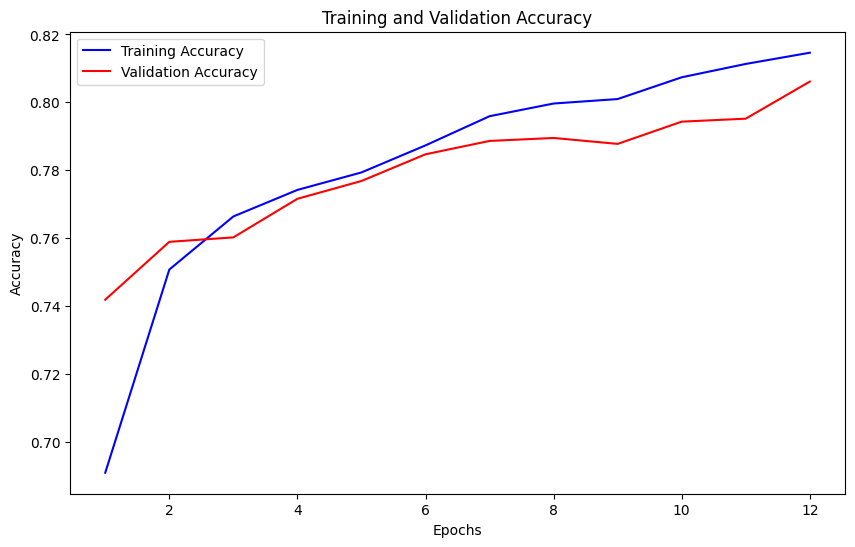

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Generate a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# best_model.fit(train_embeddings_np, train_labels_np,
#                epochs=9,  # Optimal number of epochs
#                validation_data=(val_embeddings_np, val_labels_np),
#                batch_size=32)

In [ ]:
#best_model.save('/content/drive/MyDrive/best_model.h5')

In [ ]:
best_baseline_model = load_model('/content/drive/MyDrive/best_model.h5')

In [ ]:
best_baseline_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 224)               172256    
                                                                 
 dropout_3 (Dropout)         (None, 224)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 225       
                                                                 
Total params: 172481 (673.75 KB)
Trainable params: 172481 (673.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_predictions = best_baseline_model.predict(test_embeddings_np)
test_predictions = (test_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Flatten the labels if needed
test_labels_np_flat = test_labels_np.flatten()

# Calculate additional metrics
report = classification_report(test_labels_np_flat, test_predictions, target_names=['Not Sarcastic', 'Sarcastic'])
print(report)

# Calculate and print the confusion matrix
cm = confusion_matrix(test_labels_np_flat, test_predictions)
print("Confusion Matrix:")
print(cm)

179/179 [==============================] - 0s 2ms/step
               precision    recall  f1-score   support

Not Sarcastic       0.79      0.86      0.82      2995
    Sarcastic       0.83      0.75      0.79      2729

     accuracy                           0.81      5724
    macro avg       0.81      0.81      0.81      5724
 weighted avg       0.81      0.81      0.81      5724

Confusion Matrix:
[[2576  419]
 [ 682 2047]]


In [ ]:
#np.where((test_predictions == 1) & (test_labels_np_flat == 0))

In [ ]:
test_predictions_list = test_predictions.flatten().tolist()

# Identify false positives and false negatives
false_positives = []
false_negatives = []

for i in range(len(test_predictions_list)):
    if test_predictions_list[i] == 1 and test_labels_np_flat[i] == 0:
        false_positives.append(i)
    elif test_predictions_list[i] == 0 and test_labels_np_flat[i] == 1:
        false_negatives.append(i)

# Extract 5 false positives and 5 false negatives
num_false_positives = len(false_positives)
num_false_negatives = len(false_negatives)

print(num_false_positives)
print(num_false_negatives)

[10, 22, 24]
[20, 25, 31]
419
682


In [ ]:
num_fp_to_show = min(5, len(false_positives))
num_fn_to_show = min(5, len(false_negatives))

fp_indices = false_positives[:num_fp_to_show]
fn_indices = false_negatives[:num_fn_to_show]

# Create a DataFrame to display the results
misclassified_fp = pd.DataFrame({
    'Headline': test_df.iloc[fp_indices]['headline'],
    'True Label': test_df.iloc[fp_indices]['is_sarcastic'],
    'Predicted Label': [test_predictions_list[i] for i in fp_indices]
})

misclassified_fn = pd.DataFrame({
    'Headline': test_df.iloc[fn_indices]['headline'],
    'True Label': test_df.iloc[fn_indices]['is_sarcastic'],
    'Predicted Label': [test_predictions_list[i] for i in fn_indices]
})

print("False Positives (Predicted Sarcastic, Actually Not Sarcastic):")
print(misclassified_fp)

print("\nFalse Negatives (Predicted Not Sarcastic, Actually Sarcastic):")
print(misclassified_fn)

False Positives (Predicted Sarcastic, Actually Not Sarcastic):
                                                Headline  True Label  \
843    sean spicer finally calls quits 6 months humil...           0   
6267   hotel offers ultimate sweet dreams 10pound dou...           0   
27382                       nobody wins final score 1612           0   
3673   new musical shines light paris burning star mu...           0   
1288   long island politician ever attacks opponent l...           0   

       Predicted Label  
843                  1  
6267                 1  
27382                1  
3673                 1  
1288                 1  

False Negatives (Predicted Not Sarcastic, Actually Sarcastic):
                                                Headline  True Label  \
23948        track winnings reinvested blackjack futures           1   
13987                      swiss threaten ricola embargo           1   
13073                 class clown nothing wilmot proviso           1   
79

In [ ]:
# !pip install shap

In [ ]:
# import shap


# explainer = shap.DeepExplainer(best_model, train_embeddings_np)


# shap_values = explainer(test_embeddings_np)


# shap.plots.bar(shap_values[0], max_display=16)